# Predizione e classificazione ritardo dei voli

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Alex Baiardi, Thomas Baldi, Marco Natali

##Descrizione del problema e analisi esplorativa

Si vogliono realizzare due modelli relativi al ritardo nei principali aeroporti degli Stati Uniti. Il primo in grado di determinare al momento dell'imbarco il ritardo di arrivo di un aereo. Il secondo in grado di classificare i voli in base alla fascia di ritardo di appartenenza. Per affrontare il problema di classificazione scegliamo di dividere il ritardo in quattro fasce:
- **`on_time`**
- **`0_to_30`**
- **`30_to_120`**
- **`over_120`**

Vengono importate le librerie necessarie alla gestione e visualizzazione dei dati.

In [2]:
%matplotlib inline
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime as dt

### Caricamento dei dati e preprocessing

In [3]:
file_zip_url = "https://bitbucket.org/marco_natali/data_intensive-20-21/downloads/archive.zip"
file_zip_name = "archive.zip"
file_training_set_name = "data.csv"

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

In [4]:
data_raw = pd.read_csv(file_training_set_name, sep=",")
data_raw.head()

FL_DATE OP_CARRIER  ...  LATE_AIRCRAFT_DELAY Unnamed: 27
0  2018-07-01         AA  ...                 17.0         NaN
1  2018-07-18         WN  ...                  NaN         NaN
2  2018-07-30         UA  ...                  NaN         NaN
3  2018-08-03         UA  ...                  0.0         NaN
4  2018-08-09         WN  ...                 42.0         NaN

[5 rows x 28 columns]

Di seguito sono riportate le dimensioni in memoria, il numero di istanze non nulle e il tipo delle feature che compongono i dati raccolti nel dataset 

In [5]:
data_raw.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 28 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   FL_DATE              1200000 non-null  object 
 1   OP_CARRIER           1200000 non-null  object 
 2   OP_CARRIER_FL_NUM    1200000 non-null  int64  
 3   ORIGIN               1200000 non-null  object 
 4   DEST                 1200000 non-null  object 
 5   CRS_DEP_TIME         1200000 non-null  int64  
 6   DEP_TIME             1181204 non-null  float64
 7   DEP_DELAY            1180380 non-null  float64
 8   TAXI_OUT             1180622 non-null  float64
 9   WHEELS_OFF           1180622 non-null  float64
 10  WHEELS_ON            1180028 non-null  float64
 11  TAXI_IN              1180028 non-null  float64
 12  CRS_ARR_TIME         1200000 non-null  int64  
 13  ARR_TIME             1180028 non-null  float64
 14  ARR_DELAY            1177118 non-null  float64
 15

In [6]:
def class_mapping(delay):
  if delay <= 0:
    return "on_time"
  elif delay > 0 and delay < 30:
    return "0_to_30"
  elif delay > 30 and delay < 120:
    return "30_to_120"
  else:
    return "over_120"

Aggiungiamo la colonna "DELAY_CLASS" , rappresentante la fascia di ritardo del volo. 
Di seguito il dettaglio delle classi di ritardo sopra citate:
- **`on_time`** : voli in anticipo o con ritardo pari a 0
- **`0_to_30`** : ritardo tra 0 e 30 minuti
- **`30_to_120`** : ritardo tra 30 e 120 minuti
- **`over_120`** : ritardo superiore a 120 minuti

In [7]:
data_raw["DELAY_CLASS"] = pd.Series(data_raw.ARR_DELAY.map(class_mapping))

In [8]:
data_raw.DEST.value_counts()

ATL    64930
ORD    55034
DFW    46308
DEN    39404
CLT    39069
       ...  
IFP        9
DLG        8
BKG        8
ART        7
YNG        1
Name: DEST, Length: 358, dtype: int64

### Significato delle feature


- **`FL_DATE`** indica la data del volo

- **`OP_CARRIER`** rappresenta il codice identificativo della compagnia aerea

- **`OP_CARRIER_FL_NUM`** rappresenta il numero dell'aereo

- **`ORIGIN`** indica l'aeroporto di partenza

- **`DEST`** indica l'aeroporto di destinazione

- **`CRS_DEPT_TIME`** indica l'orario di partenza previsto

- **`DEPT_TIME`** indica l'orario di partenza effettivo

- **`DEP_DELAY`** indica il ritardo di partenza in minuti

- **`TAXI_OUT`** indica il tempo trascorso tra imbarco e partenza

- **`WHEELS_OFF`** indica l'orario del decollo

- **`WHEELS_ON`** indica l'orario di atterraggio

- **`TAXI_IN`** indica il tempo trascorso tra atterraggio e arrivo in aeroporto

- **`CRS_ARR_TIME`** indica l'orario di arrivo previsto

- **`ARR_TIME`** indica l'orario di arrivo effettivo

- **`CANCELLED`** indica se il volo è stato cancellato

- **`CANCELLATION_CODE`** indica la ragione della cancellazione

- **`DIVERTED`** indica se il volo è stato deviato

- **`CRS_ELAPSED_TIME`** indica una stima del tempo di percorrenza

- **`ACTUAL_ELAPSED_TIME`** indica la durata del volo compresa delle procedure di imbarco e sbarco

- **`AIR_TIME`** indica il tempo che l'aereo trascorre in aria

- **`DISTANCE`** indica la distanza in miglia

- **`CARRIER_DELAY`**, **`WEATHER_DELAY`**, **`NAS_DELAY`**, **`SECURITY_DELAY`**, **`LATE_AIRCRAFT_DELAY`** rappresentano le possibili cause di ritardo.

Variabili target:

- **`ARR_DELAY`** indica il ritardo di arrivo in minuti

- **`DELAY_CLASS`** indica la fascia di ritardo dell'aereo.

### Cleaning dei dati


In questa sezione modifichiamo il dataset in modo da strutturarlo adeguatamente alla realizzazione delle previsioni. In particolare si eliminano features non note nel momento in cui la previsione viene effettuata (prima della partenza del volo) e alcuni record per i quali non è possibile effettuare la previsione perchè presentano valori nulli nelle variabili target.

#### Gestione valori nulli

Per prima cosa eliminiamo le feature che riportano valori non noti al momento della previsione.

In [10]:
useless_feature = ['DEP_TIME', 'TAXI_OUT',
       'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'Unnamed: 27']
data = data_raw.drop(useless_feature, axis=1)

Verifichiamo la presenza di valori nulli nel dataset.

In [11]:
data.isna().sum()

FL_DATE                  0
OP_CARRIER               0
OP_CARRIER_FL_NUM        0
ORIGIN                   0
DEST                     0
CRS_DEP_TIME             0
DEP_DELAY            19620
CRS_ARR_TIME             0
ARR_DELAY            22882
CRS_ELAPSED_TIME         3
DISTANCE                 0
DELAY_CLASS              0
dtype: int64

In [12]:
data.dropna(inplace=True)

La feature DEP_DELAY, non nota nel momento in cui si effettua la previsione, viene rimossa dal dateset e mantenuta in una serie separata, verrà poi utilizzata in fase di previsione, per valutarne l'incidenza sul modello.

In [13]:
dep_delay = data.DEP_DELAY
data.drop("DEP_DELAY",inplace=True, axis=1)

In [14]:
data.FL_DATE = pd.to_datetime(data.FL_DATE)

Si effettua un'analisi dei valori assunti dalla variabile OP_CARRIER_FL_NUM per verificarne l'utilità ai fini della previsione.

In [16]:
data.OP_CARRIER_FL_NUM.value_counts()

511     573
34      540
549     528
565     526
478     525
       ... 
6947      1
6752      1
7205      1
6736      1
7908      1
Name: OP_CARRIER_FL_NUM, Length: 7074, dtype: int64

In [17]:
data[(data.OP_CARRIER_FL_NUM == 511)].iloc[:20]

FL_DATE OP_CARRIER  ...  DISTANCE DELAY_CLASS
3079  2018-10-22         WN  ...    1246.0     on_time
4233  2018-01-18         NK  ...    1749.0     on_time
5186  2018-10-10         AA  ...     257.0     on_time
7039  2018-06-09         NK  ...     258.0   30_to_120
9490  2018-11-09         WN  ...     386.0     0_to_30
19596 2018-04-10         UA  ...     588.0     on_time
19697 2018-04-06         NK  ...    1749.0     0_to_30
20715 2018-10-27         UA  ...     588.0     on_time
22503 2018-11-01         UA  ...     977.0     on_time
23226 2018-09-02         NK  ...     258.0     on_time
25622 2018-04-22         G4  ...     701.0     on_time
26106 2018-09-09         NK  ...    1749.0     on_time
27468 2018-10-02         NK  ...    1749.0     on_time
28907 2018-09-24         UA  ...     588.0     0_to_30
28982 2018-10-17         NK  ...    1127.0     0_to_30
29743 2018-01-26         NK  ...    1749.0     on_time
30214 2018-12-26         AS  ...     937.0     0_to_30
30739 2018-11-13         UA  ...     413.0     0_to_30
30840 2018-05-20         NK  ...    1127.0    over_120
32048 2018-10-15         UA  ...     588.0     on_time

[20 rows x 11 columns]

La variabile OP_CARRIER_FL_NUM non è significativa in quanto non esprime un'informazione di interesse per la previsione da effettuare. Come possiamo vedere dalla visualizzazione precedente, uno stesso valore della variabile è associato a compagnie diverse, inoltre anche all'interno della stessa compagnia può far riferimento a tratte diverse. Di conseguenza si sceglie di trascurare e quindi eliminare la variabile. 

In [18]:
data.drop("OP_CARRIER_FL_NUM", axis=1, inplace = True)

Si procede ora all'eliminazione delle tratte che non coinvolgono gli aeroporti principali. Si è scelto di considerare i primi 50 aeroporti con più voli.
Di seguito sono visualizzati gli aeroporti presi in considerazione.

In [19]:
airports = (data.DEST.value_counts().head(50).index & data.ORIGIN.value_counts().head(50).index)
airports

Index(['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'SFO', 'PHX', 'IAH', 'LGA',
       'LAS', 'MSP', 'DTW', 'BOS', 'SEA', 'EWR', 'MCO', 'DCA', 'JFK', 'PHL',
       'SLC', 'BWI', 'FLL', 'SAN', 'MIA', 'MDW', 'TPA', 'BNA', 'DAL', 'IAD',
       'STL', 'PDX', 'AUS', 'RDU', 'HOU', 'MSY', 'MCI', 'SJC', 'OAK', 'HNL',
       'CVG', 'IND', 'PIT', 'CLE', 'SMF', 'CMH', 'SNA', 'SAT', 'MKE', 'RSW'],
      dtype='object')

In [20]:
data = data[(data.ORIGIN.isin(airports)) & (data.DEST.isin(airports))]

In [21]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 701790 entries, 1 to 1199999
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   FL_DATE           701790 non-null  datetime64[ns]
 1   OP_CARRIER        701790 non-null  object        
 2   ORIGIN            701790 non-null  object        
 3   DEST              701790 non-null  object        
 4   CRS_DEP_TIME      701790 non-null  int64         
 5   CRS_ARR_TIME      701790 non-null  int64         
 6   ARR_DELAY         701790 non-null  float64       
 7   CRS_ELAPSED_TIME  701790 non-null  float64       
 8   DISTANCE          701790 non-null  float64       
 9   DELAY_CLASS       701790 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 200.3 MB


Le variabili non continue vengono settate come categoriche, ciò riduce di circa 5 volte la memoria occupata dal dataframe.

In [22]:
categorical = ["OP_CARRIER", "ORIGIN", "DEST", "DELAY_CLASS"]
data[categorical] = data[categorical].astype("category")
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 701790 entries, 1 to 1199999
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   FL_DATE           701790 non-null  datetime64[ns]
 1   OP_CARRIER        701790 non-null  category      
 2   ORIGIN            701790 non-null  category      
 3   DEST              701790 non-null  category      
 4   CRS_DEP_TIME      701790 non-null  int64         
 5   CRS_ARR_TIME      701790 non-null  int64         
 6   ARR_DELAY         701790 non-null  float64       
 7   CRS_ELAPSED_TIME  701790 non-null  float64       
 8   DISTANCE          701790 non-null  float64       
 9   DELAY_CLASS       701790 non-null  category      
dtypes: category(4), datetime64[ns](1), float64(3), int64(2)
memory usage: 40.2 MB


### Esplorazione singole feature

Si analizzano ora le singole variabili, in particolare si porrà attenzione sulla distribuzione delle variabili target.

In [23]:
pd.DataFrame(data.ARR_DELAY.describe())

ARR_DELAY
count  701790.000000
mean        4.766224
std        44.625101
min      -117.000000
25%       -15.000000
50%        -6.000000
75%         8.000000
max      1783.000000

In [24]:
def plot_hist(data,title,label,bins = 40):
  fig,axes = plt.subplots(figsize=(10,8))
  axes.hist(data,bins=bins)
  axes.set_title(title + " bar", fontsize=18)
  axes.set_xlabel(label)

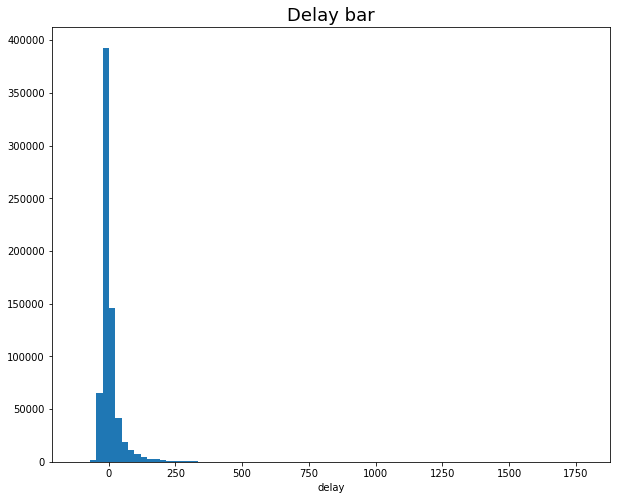

In [25]:
plot_hist(data.ARR_DELAY,"Delay","delay",80)

La prima variabile presa in considerazione è la variabile target ARR_DELAY, con la funzione describe ne visualizziamo le principali statistiche. Notiamo che il ritardo medio è di circa 5 minuti, in generale si può dire che i voli siano abbastanza puntuali, vediamo infatti che più del 50% dei voli è addirittura in anticipo. Queste informazioni sono confermate dalla rappresentazione grafica. Sono presenti alcuni ritardi elevati, ad esempio il ritardo più alto registrato è pari a 1783 minuti. Tuttavia il 75% dei voli ha un ritardo inferiore a 8 minuti, ciò preannuncia una distribuzione sbilanciata dei valori nelle classi di ritardo previste.

Di seguito viene proposta una visualizzazione della distribuzione dei valori nelle 4 classi.

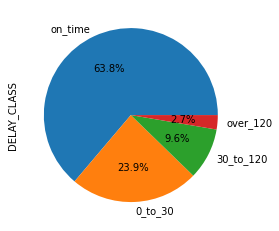

In [26]:
_=data.DELAY_CLASS.value_counts().plot.pie(autopct='%1.1f%%')

Il grafico precedente conferma quanto già affermato, notiamo infatti che il 63.8% dei voli è in orario o in anticipo, i voli con un ritardo molto alto sono presenti con una percentuale molto bassa.
Come anticipato notiamo un certo sbilanciamento nella distribuzione, questo fattore sarà sicuramente da tenere in considerazione in fase di classificazione.

Analizziamo ora la distribuzione degli orari di partenza e arrivo previsti.

I dati relativi agli orari sono rappresentati sotto forma di numeri interi nel formato hhmm, perciò, per una rappresentazione appropriata della distribuzione si suddividono gli orari della giornata in intervalli di 20 minuti: 0-19, 20-39, 40-99.Tenendo conto del fatto che i minuti non assumono un valore superiore a 59, i valori da 60 a 99 sono assimilati all'ultimo intervallo.

In [27]:
time_slices = [i*20+(i//3*40) for i in range(1,73)]

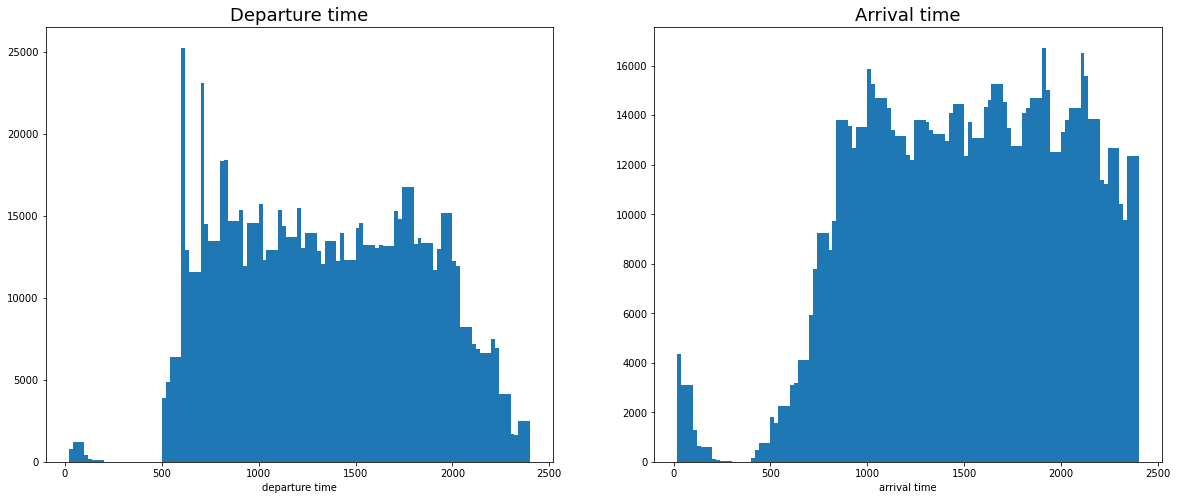

In [28]:
fig,axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 8))
axes[0].hist(data.CRS_DEP_TIME, bins=time_slices)
axes[1].hist(data.CRS_ARR_TIME, bins=time_slices)

axes[0].set_title("Departure time", fontsize = 18)
axes[1].set_title("Arrival time", fontsize = 18)
axes[0].set_xlabel("departure time")
axes[1].set_xlabel("arrival time");

I grafici mostrano che buona parte dei voli parte dalle prime ore del giorno fino alle prime ore della sera, mentre le partenze notturne sono meno frequenti. Notiamo che si hanno picchi di partenze nelle prime ore del mattino.
Per quanto concerne gli arrivi, notiamo una distribuzione più equa, in particolare buona parte dei voli arriva dalle 9 del mattino fino a mezzanotte. Si nota uno sfasamento degli orari di arrivo rispetto a quelli di partenza dovuta al tempo di percorrenza.

In [29]:
pd.DataFrame(data.CRS_ELAPSED_TIME.describe())

CRS_ELAPSED_TIME
count     701790.000000
mean         161.253013
std           77.411338
min           44.000000
25%          102.000000
50%          145.000000
75%          196.000000
max          704.000000

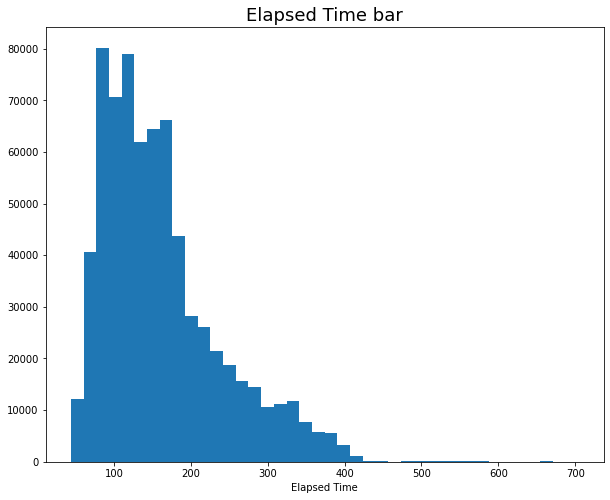

In [30]:
plot_hist(data.CRS_ELAPSED_TIME,"Elapsed Time", "Elapsed Time")

La durata media dei voli è circa di 2 ore e 40.

In [31]:
pd.DataFrame(data.DISTANCE.describe())

DISTANCE
count  701790.000000
mean      957.799694
std       633.090843
min        67.000000
25%       468.000000
50%       834.000000
75%      1235.000000
max      4983.000000

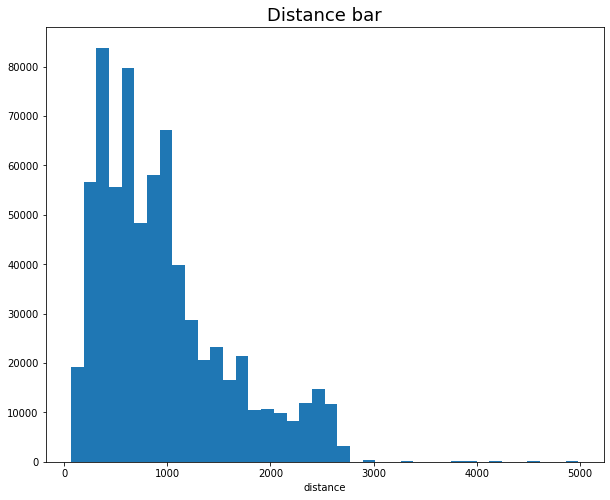

In [32]:
plot_hist(data.DISTANCE,"Distance","distance")

La distanza media coperta dai voli è di circa 958 miglia con un valore mediano di  834 miglia. Lo scostamento della media rispetto alla mediana è dovuto al fatto che il 25% dei valori è superiore a 1200 miglia fino a un massimo di quasi 5000.

In [33]:
def plot_bar(data,title,label):
  fig,axes = plt.subplots(figsize=(12,12))
  axes.barh(data.index,data, fill=True)
  axes.set_title(title + " bar", fontsize=18)
  axes.set_ylabel(label)
  axes.set_xscale("log")

Di seguito si visualizza la distribuzione delle compagnie aeree.

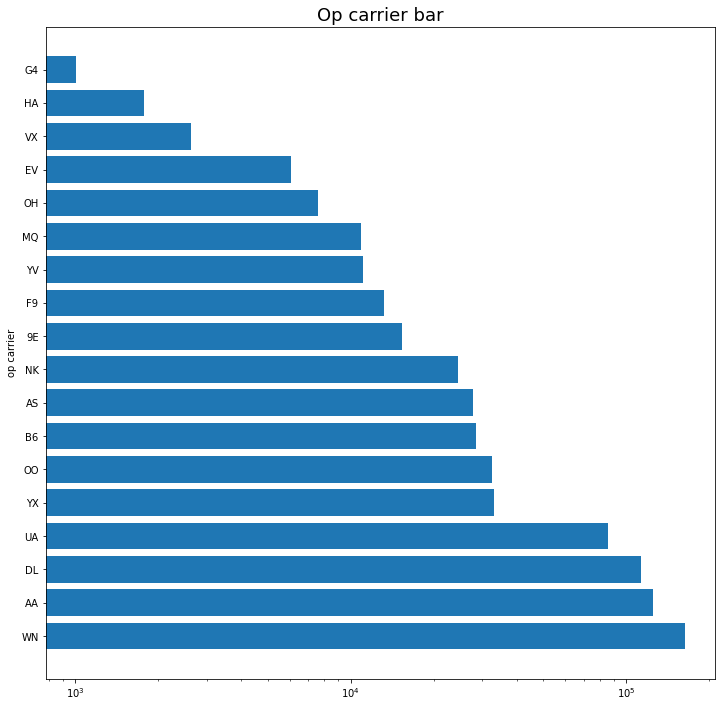

In [34]:
plot_bar(data.OP_CARRIER.value_counts(),"Op carrier", "op carrier")

Di seguito si visualizza la distribuzione dei voli sugli aeroporti.

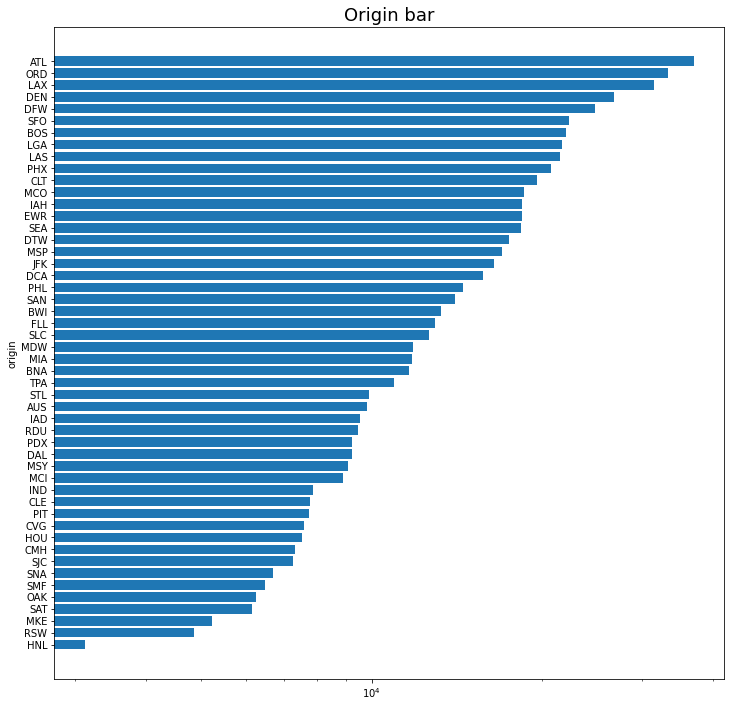

In [74]:
plot_bar(data.ORIGIN.value_counts().sort_values(), "Origin", "origin")

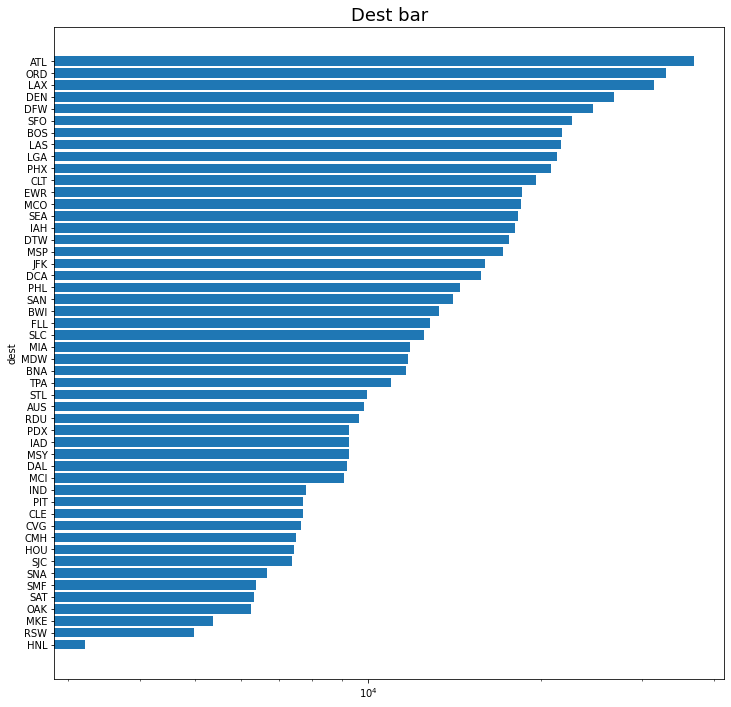

In [75]:
plot_bar(data.DEST.value_counts().sort_values(), "Dest", "dest")

### Esplorazione relazioni tra feature

Si prosegue ora all'analisi della relazione tra le feature e le variabili target.

In [37]:
def plot_influence_on_target(feature):
  tmp = data.groupby(feature).DELAY_CLASS.value_counts().unstack("DELAY_CLASS").loc[:,["on_time","0_to_30","30_to_120","over_120"]]
  tmp = pd.DataFrame(tmp.values/np.array(tmp.sum(1))[...,None] * 100,columns=tmp.columns,index=tmp.index)
  ax = tmp.plot.bar(width = 0.9,figsize=(25,8), ylabel="Percent")
  _ = ax.legend(loc = "best", ncol=4)

In [38]:
def plot_time_on_target(feature):
  tmp = data.groupby(pd.cut(data[feature],np.arange(0,2401,100)).cat.remove_unused_categories()).DELAY_CLASS.value_counts().unstack("DELAY_CLASS").loc[:,["on_time","0_to_30","30_to_120","over_120"]]
  tmp = pd.DataFrame(tmp.values/np.array(tmp.sum(1))[...,None] * 100,columns=tmp.columns,index=tmp.index)
  ax = tmp.plot.bar(width = 0.9,figsize=(20,8), ylabel="Percent")
  _ = ax.legend(loc = "best", ncol=4)

In [39]:
def plot_data_on_target(feature):
  tmp = data.groupby(pd.cut(data[feature],np.arange(100,1201,100))).DELAY_CLASS.value_counts().unstack("DELAY_CLASS").loc[:,["on_time","0_to_30","30_to_120","over_120"]]
  tmp = pd.DataFrame(tmp.values/np.array(tmp.sum(1))[...,None] * 100,columns=tmp.columns,index=tmp.index)
  ax = tmp.plot.bar(width = 0.9,figsize=(20,8), ylabel="Percent")
  _ = ax.legend(loc = "best", ncol=4)

La prima feature in analisi è la compagnia aerea. Nel grafico viene mostrata la distribuzione dei valori nelle 4 classi di ritardo. Sull'asse delle ordinate viene mostrato in percentuale la quantità di valori per ciascuna classe. 

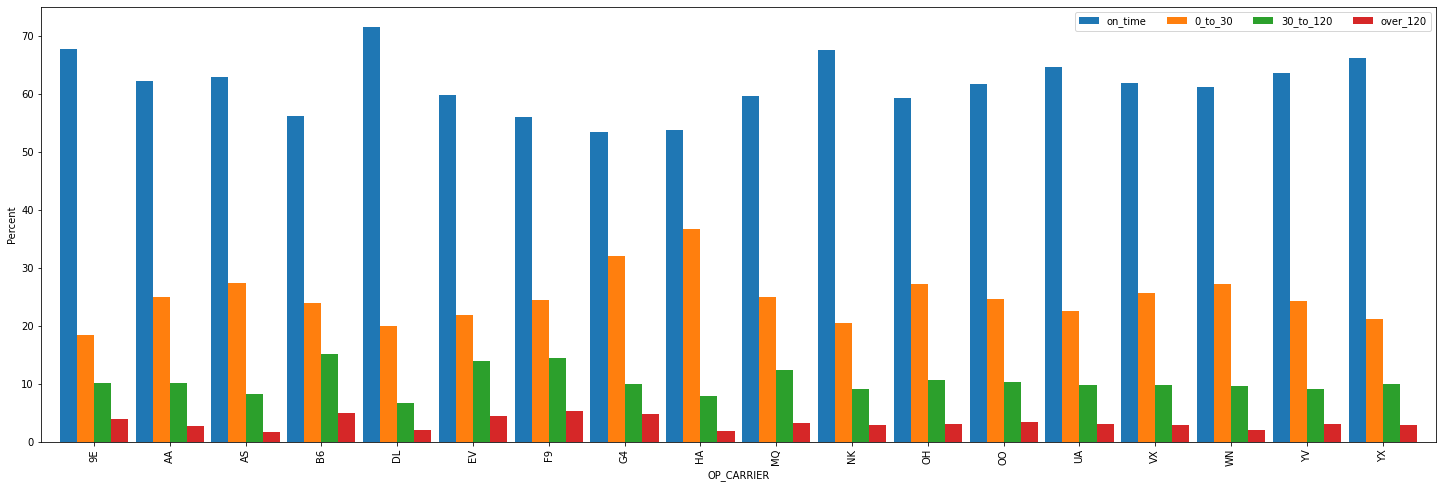

In [43]:
plot_influence_on_target("OP_CARRIER")

Si può notare come la compagnia possa essere un parametro utile alla previsione infatti le percentuali di appartenza alle classi non sono costanti. Alcune compagnie hanno percentualmente più voli in orario rispetto ad altre.

Analizziamo ora il la distribuzione del ritardo nelle varie classi in relazione all'aeroporto di origine e destinazione.

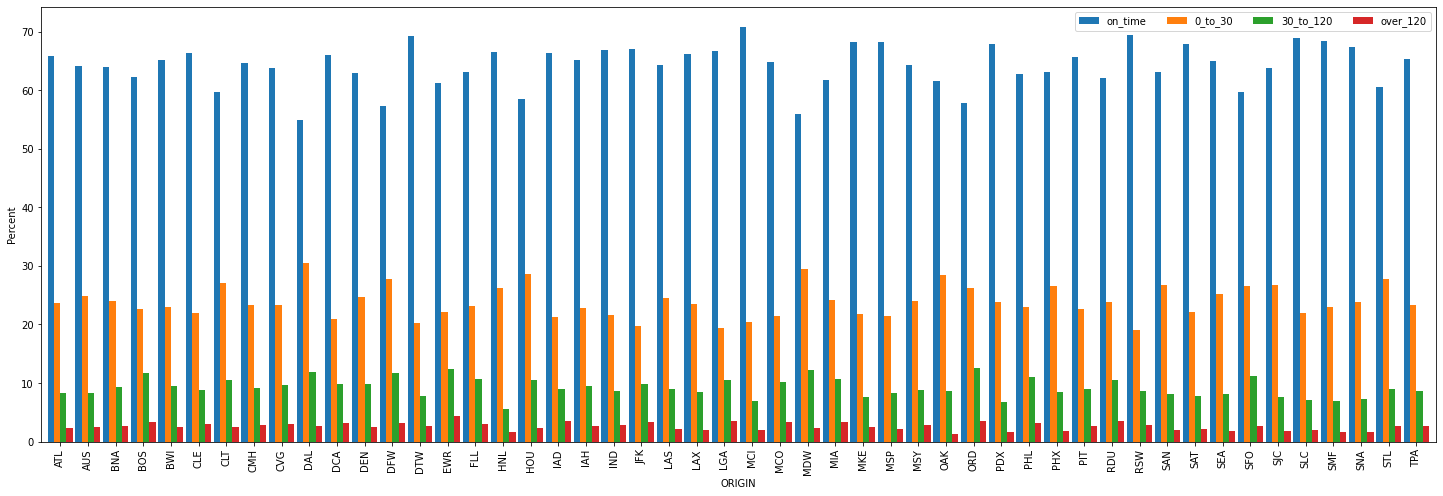

In [44]:
plot_influence_on_target("ORIGIN")

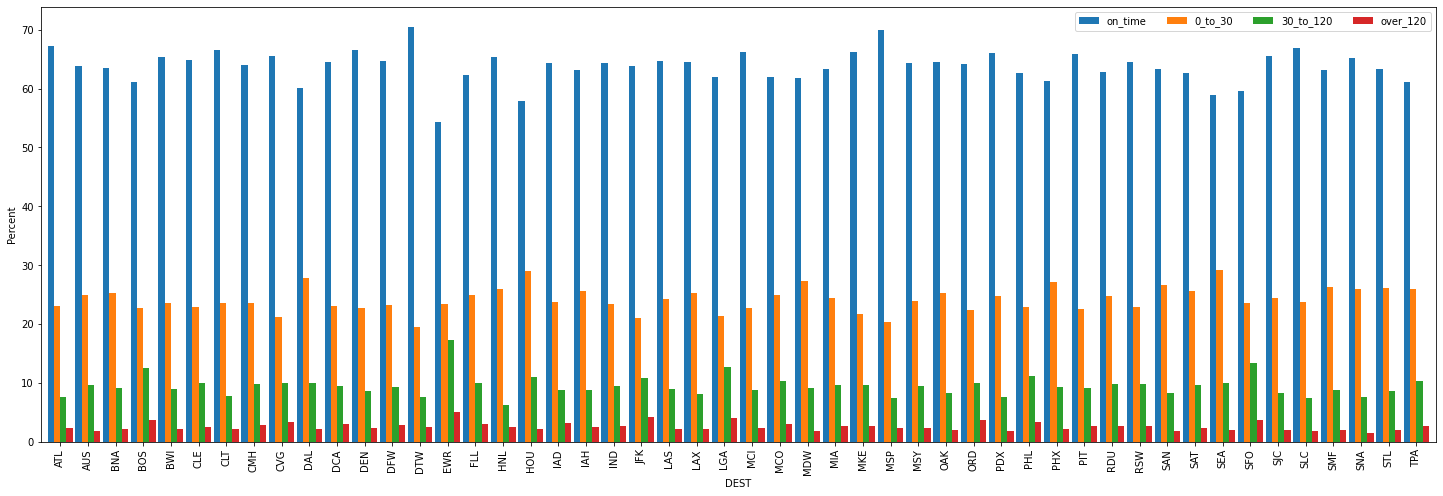

In [45]:
plot_influence_on_target("DEST")

Anche l'aeroporto di origine/destinazione, come la compagnia aerea, potrebbe essere un parametro rilevante per la previsione del ritardo. In alcuni casi notiamo differenze anche importanti tra un aeroporto e l'altro. Ad esempio l'aeroporto MCI(Kansas City International Airport, Missouri), specialmente nelle tratte in uscita, ha circa il 70% dei voli in orario e pochi voli con ritardo medio - lungo o lungo. Si può invece notare come altri aeroporti abbiano molti voli in ritardo, ad esempio EWR (Newark Liberty International Airport, New Jersey), specialmente nelle tratte in entrata, ha poco più del 50% di voli in orario, mentre conta quasi il 20% di voli con ritardo medio - lungo e più del 5% con ritardo lungo.

Analizziamo ora l'influenza degli orari di partenza/arrivo stimati sul ritardo. I primi due grafici mettono in relazione l'orario con la misura del ritardo (variabile target ARR_DELAY). Gli altri due grafici mostrano invece, per ogni ora, la distribuzione dei voli di quell'ora nelle 4 classi di ritardo. 

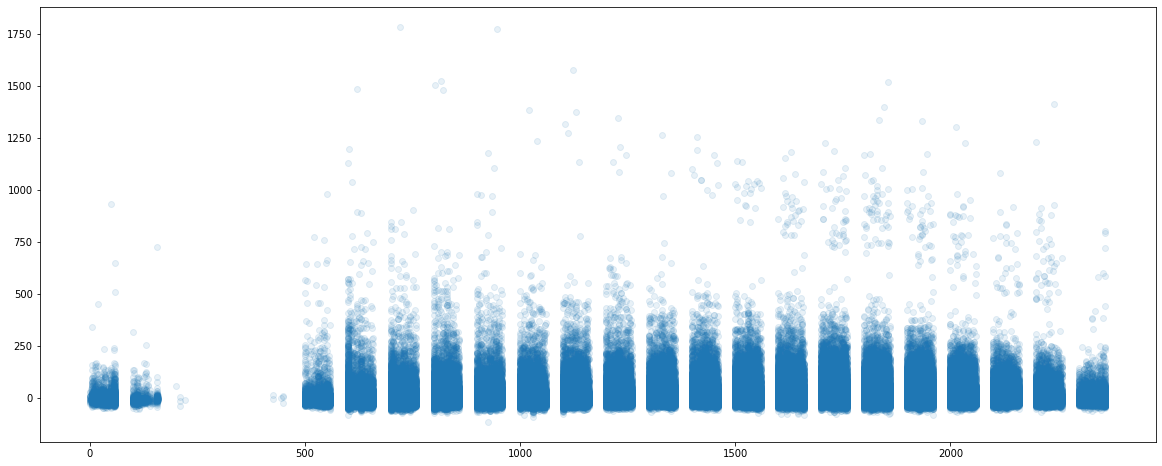

In [46]:
plt.figure(figsize=(20,8))
_ = plt.scatter(data.CRS_DEP_TIME,data.ARR_DELAY, alpha=0.1)

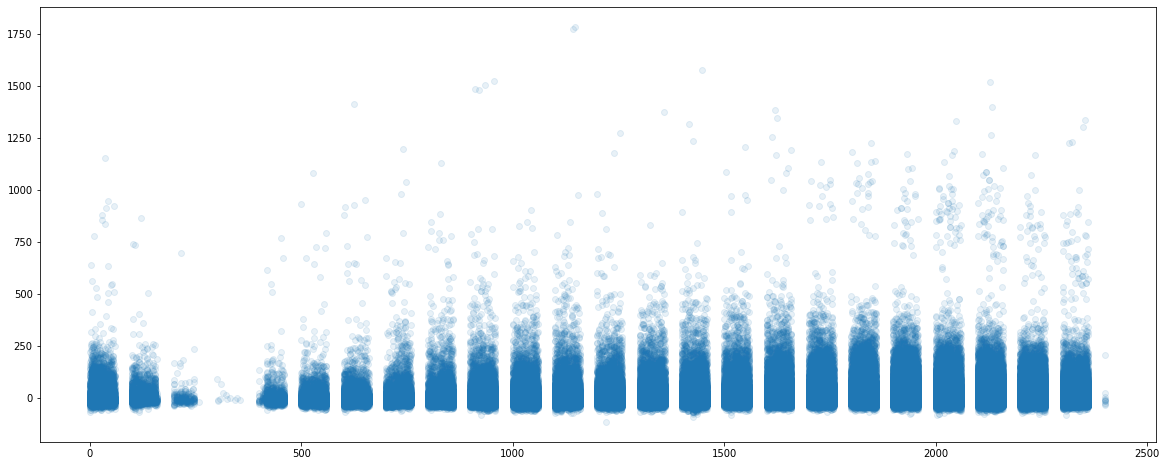

In [47]:
plt.figure(figsize=(20,8))
_ = plt.scatter(data.CRS_ARR_TIME,data.ARR_DELAY, alpha=0.1)

Da questi primi due grafici notiamo che i ritardi lunghi si accumulano in particolare nei voli che partono/arrivano nelle ore del tardo pomeriggio e della sera.

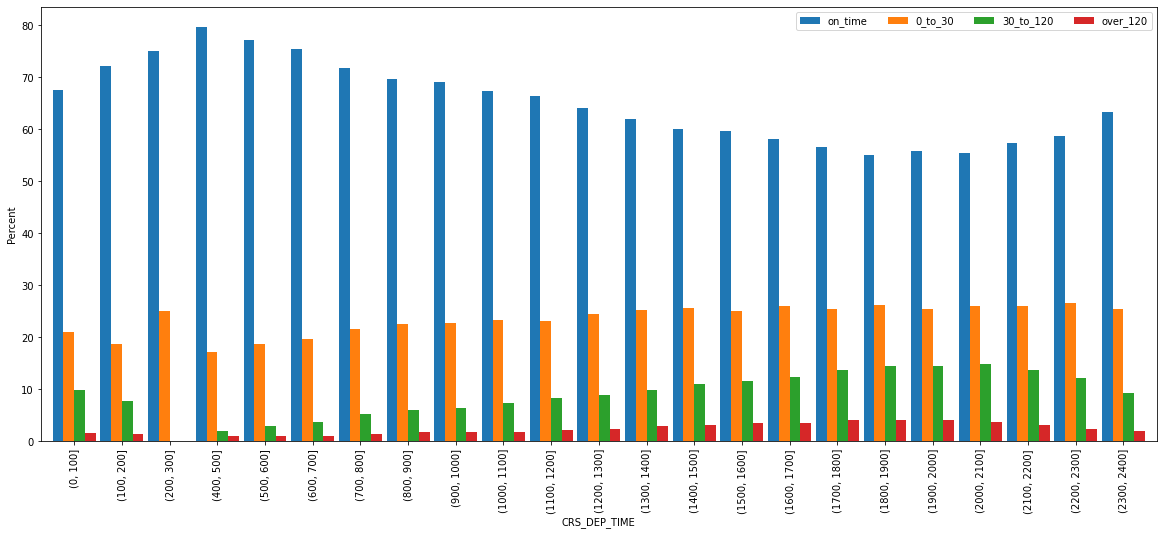

In [48]:
plot_time_on_target("CRS_DEP_TIME")

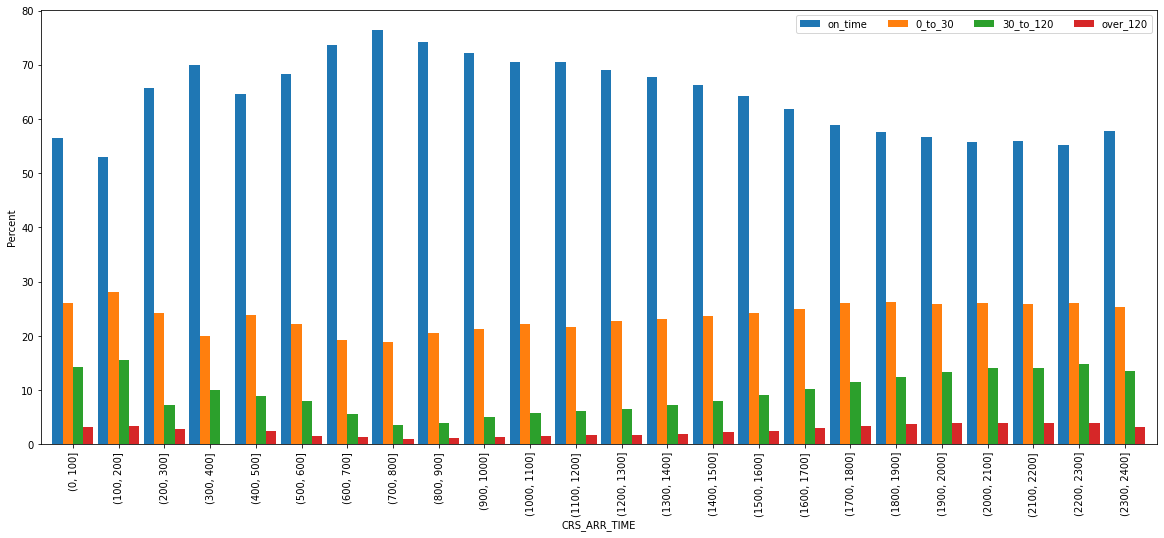

In [49]:
plot_time_on_target("CRS_ARR_TIME")

La distribuzione del ritardo nelle ore conferma quanto detto in precedenza, notiamo anche che i ritardi brevi sono abbastanza costanti lungo le ore del giorno, i ritardi medio lunghi sono invece più alti nelle ore della sera e nelle prime ore dopo la mezzanotte, conseguentemente, in queste ore la percentuale di voli in orario diminuisce.

Prendiamo in considerazione la data del volo.

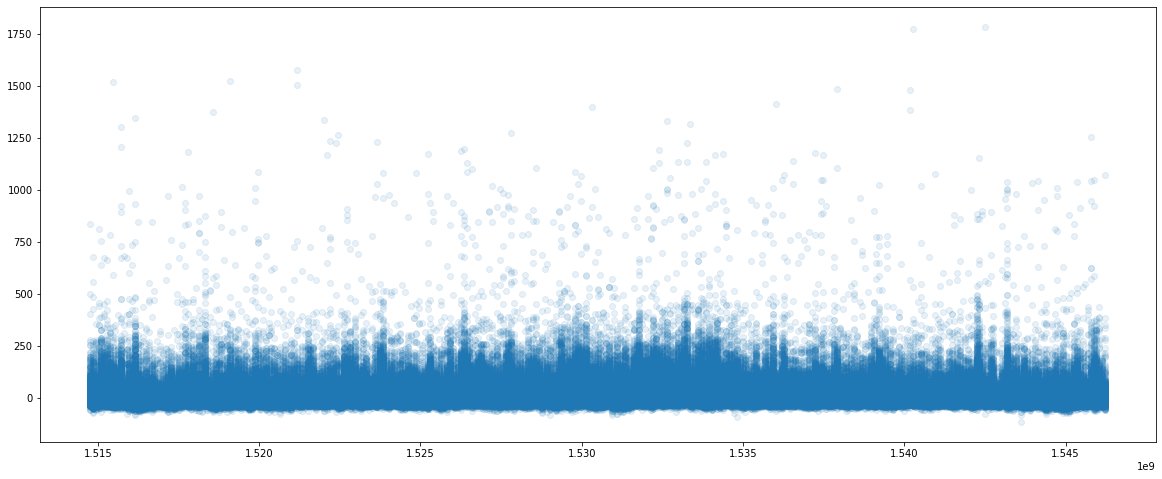

In [76]:
plt.figure(figsize=(20,8))
_ = plt.scatter(data.FL_DATE, data.ARR_DELAY, alpha=0.1)

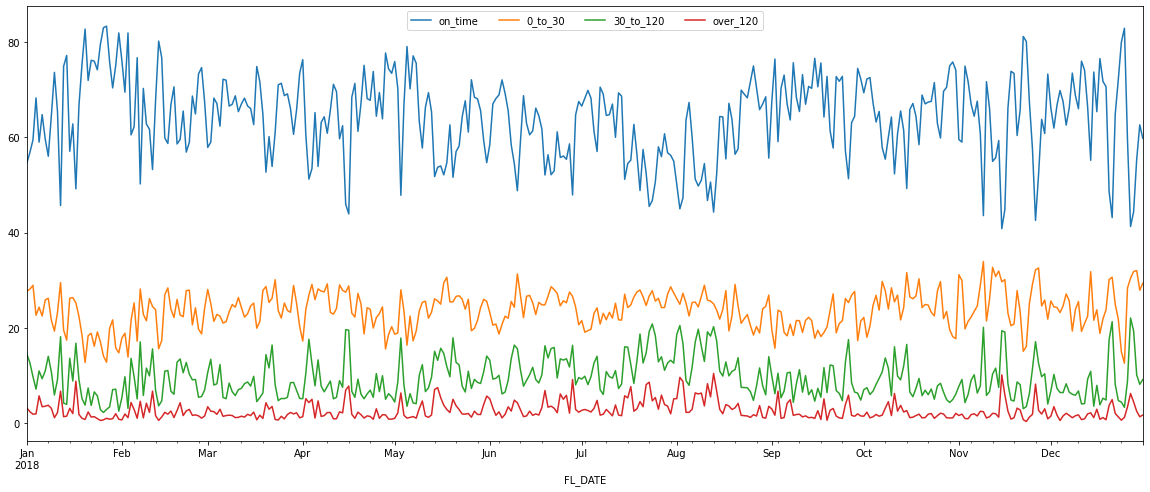

In [50]:
tmp = data.groupby(data.FL_DATE).DELAY_CLASS.value_counts().unstack("DELAY_CLASS").loc[:,["on_time","0_to_30","30_to_120","over_120"]]
tmp = pd.DataFrame(tmp.values/np.array(tmp.sum(1))[...,None] * 100,columns=tmp.columns,index=tmp.index)
ax = tmp.plot.line(figsize=(20,8))
_ = ax.legend(loc="upper center", ncol=4)

Dal grafico notiamo che nei mesi estivi si ha una percentuale più bassa di voli in orario. In generale si vede come l'andamento sia altalenante, ciò potrebbe essere imputabile a diversi fattori quali il giorno della settimana, il meteo ecc... 
<br>Essendo il giorno della settimana l'unico a nostra disposizione si valuta l'incidenza di questa variabile sul ritardo. 

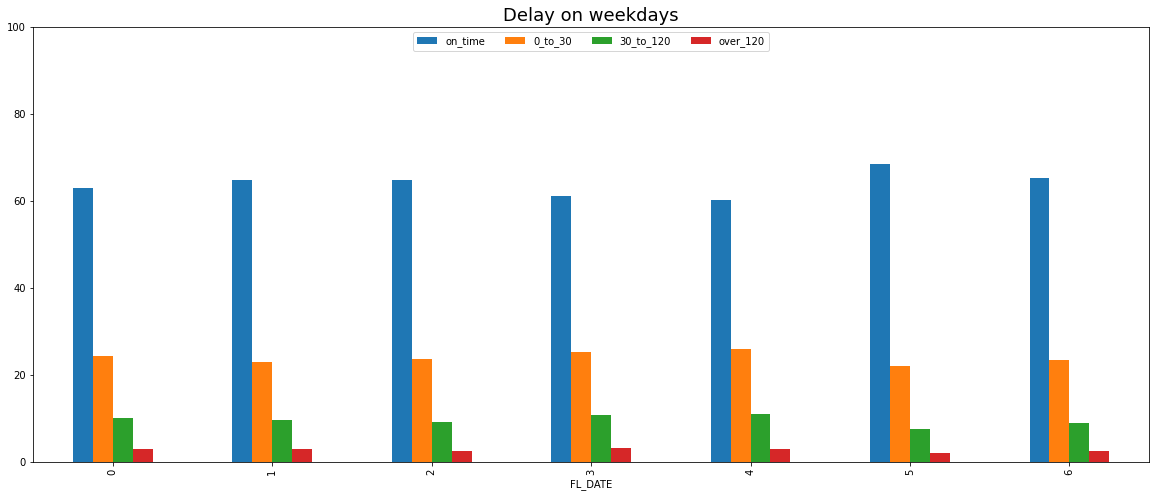

In [51]:
tmp = data.groupby(data.FL_DATE.dt.dayofweek).DELAY_CLASS.value_counts().unstack("DELAY_CLASS").loc[:,["on_time","0_to_30","30_to_120","over_120"]]
tmp = pd.DataFrame(tmp.values/np.array(tmp.sum(1))[...,None] * 100,columns=tmp.columns,index=tmp.index)
ax = tmp.plot.bar(figsize=(20,8))
ax.legend(loc="upper center", ncol=4)
ax.set_ylim(0,100)
_ = ax.set_title("Delay on weekdays", fontsize=18)

Dal grafico si nota una distribuzione simile, tuttavia vediamo come il Giovedì e il Venerdì i voli siano leggermente in ritardo rispetto agli altri giorni. Relazioniamo ora il ritardo alla coppia mese - giorno della settimana per vedere se possa incidere.

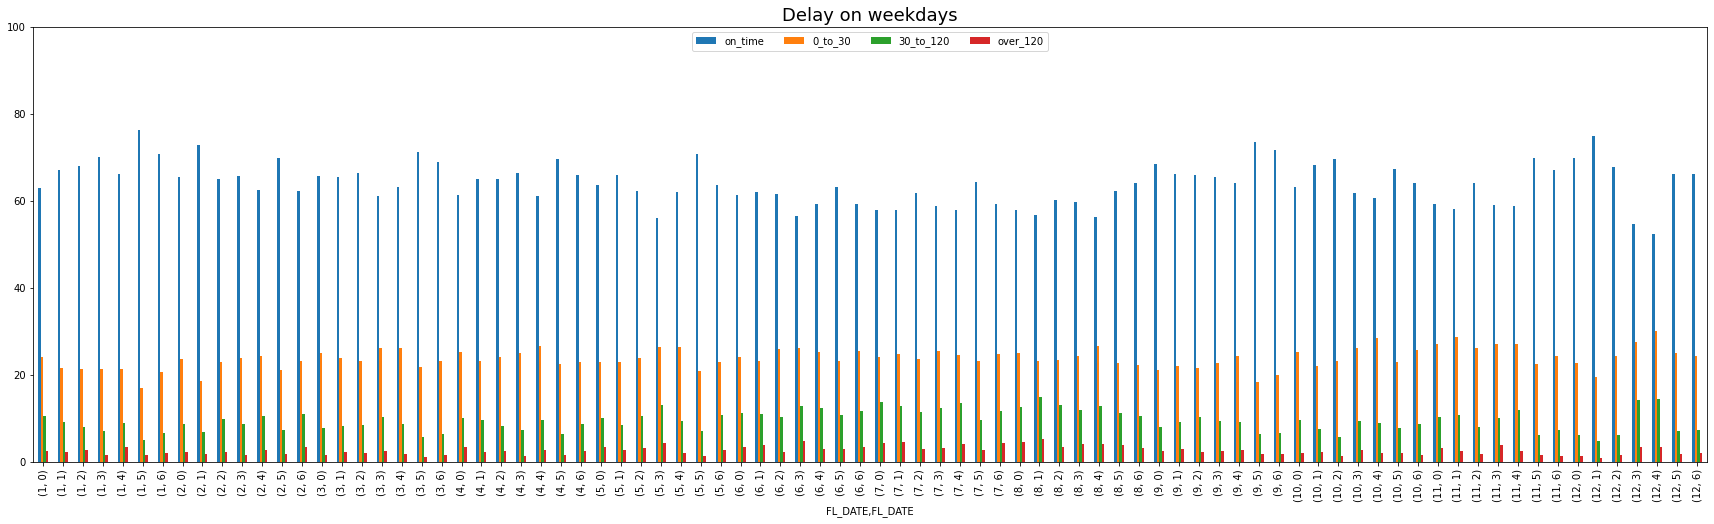

In [52]:
tmp = data.groupby([data.FL_DATE.dt.month,data.FL_DATE.dt.dayofweek]).DELAY_CLASS.value_counts().unstack("DELAY_CLASS").loc[:,["on_time","0_to_30","30_to_120","over_120"]]
tmp = pd.DataFrame(tmp.values/np.array(tmp.sum(1))[...,None] * 100,columns=tmp.columns,index=tmp.index)
ax = tmp.plot.bar(figsize=(30,8))
ax.legend(loc="upper center", ncol=4)
ax.set_ylim(0,100)
_ = ax.set_title("Delay on weekdays", fontsize=18)

Il grafico presenta un andamento abbastanza costante e conferma quanti visto in precedenza, di conseguenza, per ora, si decide di mantenere la data per intero senza aggiungere feature relative a mese e giorno della settimana.

In [53]:
data.FL_DATE = (data.FL_DATE - dt.datetime(1970,1,1)).dt.total_seconds()

Servendosi di una heatmap viene ora mostrato il grado di correlazione esistente tra le variabili.

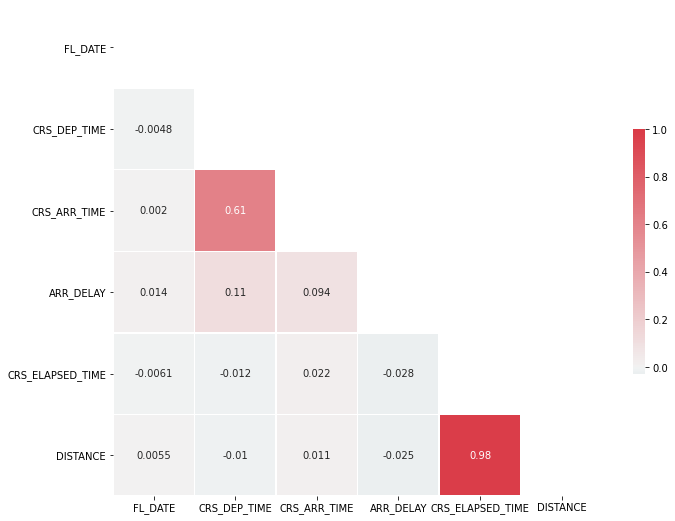

In [54]:
tmp = data.corr()
cmap = sb.diverging_palette(220, 10, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(tmp, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(tmp, mask=mask, cmap=cmap, vmax=1, center=0,annot = True, square=True, linewidths=.5, cbar_kws={"shrink": .5});

##Preparazione del dataset

Rappresentate le feature e le loro relazioni con le variabili target, si passa ora alla preparazione del dataset per le fasi successive. In particolare si suddivide il dataset in 3 parti:
- training set: 55% del totale
- validation set : 25% del totale
- test set: 20% del totale

In [55]:
X = data.drop(["ARR_DELAY","DELAY_CLASS"], axis=1)
Y = data[["ARR_DELAY","DELAY_CLASS"]]

Divisione in training set e validation set.

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.45, random_state=99)

Estrazione del test set dal validation set.

In [57]:
X_val,X_test,Y_val,Y_test = train_test_split(X_val,Y_val, test_size = 0.45, random_state=99)

Suddividiamo ora i dati nei set necessari per effettuare regressione e classificazione.

In [58]:
y_train_regr, y_train_class = Y_train.ARR_DELAY,Y_train.DELAY_CLASS
y_val_regr, y_val_class, = Y_val.ARR_DELAY,Y_val.DELAY_CLASS
y_test_regr, y_test_class = Y_test.ARR_DELAY,Y_test.DELAY_CLASS

##Modelli di regressione

In questa sezione si procede alla realizzazione di modelli di regressione in grado di predire il ritardo.

Per prima cosa definiamo delle funzioni che preso in input il modello lo addestrino e ne valutino l'accuratezza. Come misure di accuratezza scegliamo di utilizzare il coefficiente R<sup>2</sup>, l'errore quadratico medio (MSE) e l'errore medio assoluto (MAE). Abbiamo scelto di non utilizzare come metrica l'errore relativo perchè nei punti in cui il ritardo è pari a 0 avremmo un valore dell'errore pari a infinito.



In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [ ]:
def get_coefficients(model, index, model_name="model"):
    return pd.Series(model.named_steps[model_name].coef_, index=index)
    
def fit_and_eval(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print("R-squared coefficient: {:.5}".format(model.score(X_val, y_val)))
    print("MSE: {:.5}".format(mean_squared_error(y_val,y_pred)))
    print("MAE: {:.5}".format(mean_absolute_error(y_val,y_pred)))

In [ ]:
def grid_search_with_cross_validation(model, grid, X_train,y_train,X_val,y_val,n_folds=5):    
    kf = KFold(n_folds,shuffle=True,random_state=99)
    grid_search = GridSearchCV(model, grid, cv=kf, n_jobs=-1)
    grid_search.fit(X_train, y_train)    
    score = grid_search.score(X_val, y_val)
    print("Best cross validation score: {}\n".format(grid_search.best_score_))
    print("             Test set score: {}\n".format(score))
    print("                Best params: {}\n".format(grid_search.best_params_))
    return grid_search    

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, Ridge, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor 

Si suddividono le variabili in categoriche e numeriche in modo da applicare transformazioni personalizzate.

In [60]:
categorical_features = ["OP_CARRIER","ORIGIN", "DEST"]
numerical_features = ["FL_DATE","CRS_DEP_TIME","CRS_ARR_TIME","CRS_ELAPSED_TIME","DISTANCE"]

In [61]:
y_train, y_val = y_train_regr, y_val_regr

###Modelli di regressione lineare

Il primo algoritmo preso in considerazione è una semplice regressione lineare. Abbiamo scelto di partire da un algoritmo semplice per avere una stima iniziale dell'accuratezza che verrà poi migliorata adottando man mano modelli più complessi.

In [ ]:
linear_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("reg", LinearRegression())
])

In [ ]:
fit_and_eval(linear_model,X_train,y_train,X_val,y_val)

R-squared coefficient: 0.02638
MSE: 1979.0
MAE: 22.943


Si nota come un semplice modello lineare non sia adatto alla previsione del ritardo, si prova ora ad aggiungere regolarizzazione per ridurre la complessità e mantenere basso il valore dei coefficienti.
Proviamo aggiungendo regolarizzazione L1,L2 e una combinazione delle 2 con un modello ElasticNet.

In [ ]:
grid = [
    {
        "reg" : [Lasso(),Ridge()],
        "reg__alpha": [0.01, 0.1, 1, 10]
    },
    {
        "reg" : [ElasticNet()],
        "reg__l1_ratio": [0.2, 0.5],
        "reg__alpha": [0.01, 0.1, 1, 10]
    }
]

In [ ]:
linear_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder(), categorical_features)                       
       ])),
       ("reg", LinearRegression())
])

In [ ]:
gs = grid_search_with_cross_validation(linear_model,grid,X_train,y_train,X_val,y_val)

Best cross validation score: 0.025761607824010224

             Test set score: 0.02637276283347434

                Best params: {'reg': Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001), 'reg__alpha': 10}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['FL_DATE', 'CRS_DEP_TIME',
                                                   'CRS_ARR_TIME',
   

In [ ]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(10)

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
9        0.780753      0.004742  ...        0.001307                1
5        0.768537      0.020947  ...        0.001306                2
7        0.781487      0.009570  ...        0.001307                3
8        0.778540      0.009621  ...        0.001304                4
6        0.774369      0.005556  ...        0.001303                5
0      160.787988      0.423842  ...        0.001305                6
11     148.909288      0.887830  ...        0.001305                7
10     150.799140      0.504967  ...        0.001305                8
1       67.056085      3.424296  ...        0.001323                9
13      42.479984      1.249132  ...        0.001263               10

[10 rows x 16 columns]

Modello migliore

In [76]:
ridge_model = gs.best_estimator

In [ ]:
model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder(), categorical_features)                       
       ])),
       ("reg", Lasso(0.01))
])
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['FL_DATE', 'CRS_DEP_TIME',
                                                   'CRS_ARR_TIME',
                                                   'CRS_ELAPSED_TIME',
                                                   'DISTANCE']),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                                      

In [ ]:
col = numerical_features + list(model.named_steps.preproc.named_transformers_.categorical.get_feature_names(categorical_features))
print(get_coefficients(model,col,"reg").sort_values(key= lambda x: abs(x), ascending=False).to_string())

DEST_EWR            12.445714
OP_CARRIER_F9        9.061930
CRS_ELAPSED_TIME    -8.206115
DEST_SFO             7.424979
DISTANCE             6.749595
ORIGIN_EWR           5.783940
OP_CARRIER_DL       -5.489744
OP_CARRIER_B6        5.405615
OP_CARRIER_HA        5.366245
DEST_LGA             4.938560
DEST_ORD             4.786582
ORIGIN_ORD           4.413462
DEST_SEA             4.143594
OP_CARRIER_AS       -4.137524
DEST_HNL             3.917328
OP_CARRIER_YX       -3.866895
CRS_DEP_TIME         3.605344
ORIGIN_HNL          -3.347977
ORIGIN_DFW           3.341494
DEST_DFW             3.196913
ORIGIN_SMF          -3.168058
ORIGIN_MCI          -3.072662
ORIGIN_LAX          -3.006765
ORIGIN_SNA          -2.984572
ORIGIN_MIA           2.939997
ORIGIN_SLC          -2.898701
DEST_JFK             2.849322
ORIGIN_PDX          -2.811838
OP_CARRIER_EV        2.648913
ORIGIN_DAL           2.600662
OP_CARRIER_OO        2.398743
ORIGIN_MDW           2.367367
OP_CARRIER_UA       -2.337570
DEST_PHX  

Anche applicando regolarizzazione l'accuratezza del modello non migliora, un comportamento comunque prevedibile in quanto i dati non hanno un andamento lineare. Analizziamo i coefficienti della Lasso per individuare le feature più rilevanti nella previsione. Ad esempio notiamo che il peso maggiore è dato alla variabile DEST con valore EWR, dal grafico dei ritardi notiamo infatti che i voli che hanno questo aeroporto come destinazione sono tendelzialmente in ritardo. In generale i coefficienti attribuiti dalla Lasso sono coerenti con quanto visto nei grafici.

###Modelli di regressione non lineare

Proviamo ora a considerare dei modelli non lineari, con lo scopo di descrivere più accuratamente i dati.

####Modelli polinomiali

Il primo modello preso in considerazione è un modello polinomiale, si testano polinomi di grado 2,4 e 6. In questa fase, non utilizzando funzioni Kernel, si tiene il grado basso per evitare la proliferazione delle feature.

In [ ]:
grid = [
    {
        "preproc__numeric__poly__degree" : [2,4,6],
        "reg" : [LinearRegression()]
    },    
    {
        "preproc__numeric__poly__degree" : [2,4,6],
        "reg" : [Lasso(),Ridge()],
        "reg__alpha": [0.01, 0.1, 1, 10]
    }
]

In [ ]:
polynomial_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , Pipeline([
                                     ("scale", StandardScaler()),
                                     ("poly", PolynomialFeatures(include_bias=False))
          ]), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("reg",LinearRegression())
])

In [ ]:
gs = grid_search_with_cross_validation(polynomial_model,grid,X_train,y_train,X_val,y_val)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best cross validation score: 0.03661474718781939

             Test set score: 0.03767809834702285

                Best params: {'preproc__numeric__poly__degree': 6, 'reg': Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001), 'reg__alpha': 10}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('scale',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
           

In [ ]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(10)

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
26       9.790665      0.135125  ...        0.001142                1
25      10.554451      1.042221  ...        0.001133                2
24      12.078904      0.083991  ...        0.001101                3
23      12.101776      0.152201  ...        0.001100                4
2       35.443677      1.931620  ...        0.001149                5
19     689.825095      6.617886  ...        0.001457                6
17       3.126787      0.074294  ...        0.001552                7
16       2.995792      0.100254  ...        0.001536                8
15       3.118182      0.151480  ...        0.001523                9
1       14.143314      0.399205  ...        0.001521               10

[10 rows x 16 columns]

Modello migliore

In [76]:
polynomial_model = gs.best_estimator_

L'utilizzo di feature polinomiali migliora l'accuratezza del modello che rimane tuttavia, in generale, poco accurato. 
Si provano di seguito le funzioni Kernel che ci permettono di aumentare il grado senza introdurre maggiore complessità. In questa fase è importante considerare che il dataset è di dimensioni particolarmente elevate e che le funzioni Kernel si basano sul prodotto tra matrici. Di conseguenza per evitare di processare matrici di dimensioni elevate che porterebbero alla saturazione della memoria, si sceglie di considerare fin da subito un'approssimazione delle stesse. Al posto di una funzione Kernel pura, si è scelto di utilizzare il filtro Nystroem che ci permette di approssimare il Kernel riducendo la dimensionalità della matrice e, conseguentemente, anche la complessità.
Prima di intraprendere questa strada è stata comunque testata una soluzione con KernelRidge, tuttavia, l'addestramento del modello si è dimostrato molto lungo e complesso senza che ciò giovasse alla previsione. 

In [ ]:
grid = [ 
    {
        "preproc__numeric__nys__degree" : [10,15],
        "preproc__numeric__nys__n_components" : [1500],
        "preproc__numeric__nys__kernel" : ["poly","rbf"],
        "reg__alpha" : [10,100]        
    }
]

In [ ]:
nystroem_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , Pipeline([
                 ("scale",StandardScaler()),
                 ("nys", Nystroem())                    
          ]), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("reg", Ridge())
])

In [ ]:
gs = grid_search_with_cross_validation(nystroem_model,grid,X_train,y_train,X_val,y_val,3)

Best cross validation score: 0.03517508693124357

             Test set score: 0.03638671787834258

                Best params: {'preproc__numeric__nys__degree': 15, 'preproc__numeric__nys__kernel': 'rbf', 'preproc__numeric__nys__n_components': 1500, 'reg__alpha': 10}



Modello migliore

In [76]:
nystroem_model = gs.best_estimator_

L'aumento di grado non migliora l'accuratezza. Il risultato migliore si è ottenuto con un polinomio di grado 6. Il fatto che un polinomio di grado 15 abbia dato un risultato peggiore può comunque essere imputabile al fatto che questo polinomio è stato testato su un'approssimazione abbastanza forte della Kernel matrix, per motivi legati alle risorse necessarie per il calcolo. 

####Alberi di regressione

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

Si valutano ora modelli basati su alberi di regressione. Il primo modello preso in considerazione è un semplice DecisionTree.

In [ ]:
grid = [
        { 
            "tree__max_depth" : [15,20,25],
            "tree__min_samples_split" : [0.008,0.006]
        }
]

In [ ]:
tree_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric", "passthrough", numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("tree", DecisionTreeRegressor())
])

In [ ]:
gs = grid_search_with_cross_validation(tree_model,grid,X_train,y_train,X_val,y_val)

Best cross validation score: 0.04225486110951535

             Test set score: 0.046389865906865224

                Best params: {'tree__max_depth': 20, 'tree__min_samples_split': 0.006}



In [ ]:
col = numerical_features + list(gs.best_estimator_.named_steps.preproc.named_transformers_.categorical.get_feature_names(categorical_features))

In [ ]:
print(export_text(gs.best_estimator_.named_steps.tree,max_depth=5, feature_names=col))

|--- CRS_DEP_TIME <= 1300.50
|   |--- CRS_DEP_TIME <= 815.50
|   |   |--- OP_CARRIER_F9 <= 0.50
|   |   |   |--- CRS_DEP_TIME <= 702.50
|   |   |   |   |--- OP_CARRIER_OO <= 0.50
|   |   |   |   |   |--- OP_CARRIER_YV <= 0.50
|   |   |   |   |   |   |--- truncated branch of depth 15
|   |   |   |   |   |--- OP_CARRIER_YV >  0.50
|   |   |   |   |   |   |--- value: [8.61]
|   |   |   |   |--- OP_CARRIER_OO >  0.50
|   |   |   |   |   |--- value: [2.75]
|   |   |   |--- CRS_DEP_TIME >  702.50
|   |   |   |   |--- CRS_ELAPSED_TIME <= 184.50
|   |   |   |   |   |--- DEST_SFO <= 0.50
|   |   |   |   |   |   |--- truncated branch of depth 15
|   |   |   |   |   |--- DEST_SFO >  0.50
|   |   |   |   |   |   |--- value: [12.42]
|   |   |   |   |--- CRS_ELAPSED_TIME >  184.50
|   |   |   |   |   |--- OP_CARRIER_DL <= 0.50
|   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |--- OP_CARRIER_DL >  0.50
|   |   |   |   |   |   |--- value: [-8.27]
|   |   |--- OP_CARRIER_F9

Modello migliore

In [ ]:
decision_tree_model = gs.best_estimator_

Da questi primi risultati ottenuti notiamo che un modello ad albero potrebbe essere più indicato alla previsione in quanto risulta migliore dei modelli visti in precedenza, si prova a migliorare ulteriormente sfruttando foreste di alberi. 

Inizialmente si sceglie di utilizzare RandomForest.

In [ ]:
grid = [
        { 
            "tree__max_depth" : [8,12],
            "tree__min_samples_split" : [0.01,0.008],
            "tree__n_estimators" : [300]
        }
]

In [ ]:
random_forest = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric", "passthrough", numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("tree", RandomForestRegressor(random_state=99))
])

In [ ]:
gs = grid_search_with_cross_validation(tree_model,grid,X_train,y_train,X_val,y_val)

Best cross validation score: 0.04496508598542026

             Test set score: 0.04582146960841227

                Best params: {'tree__max_depth': 12, 'tree__min_samples_split': 0.008, 'tree__n_estimators': 300}



Modello migliore

In [ ]:
random_forest_model = gs.best_estimator_

L'utilizzo di una foresta migliora leggermente l'accuratezza del modello, non si ha comunque un incremento significativo. Si potrebbe ottenere un risultato migliore utilizzando algoritmi di gradient boosting. Si prova quindi ad utilizzare XGBoost.

In [ ]:
"""grid = [
        {
            'tree__colsample_bytree': [0.5,0.6], 
            'tree__learning_rate': [0.01], 
            'tree__max_depth': [15,18], 
            'tree__min_child_weight': [10, 12], 
            'tree__n_estimators': [800,1000],
            'tree__reg_alpha': [4,5], 
            'tree__reg_lambda': [2,3]
        }
]
tree_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("tree", XGBRegressor(random_state=99,objective='reg:squarederror'))
])
gs = grid_search_with_cross_validation(tree_model,grid,X_train,y_train,X_val,y_val)"""

Di seguito sono riportati i parametri migliori individuati dalla grid search. Abbiamo scelto di mostrare direttamente i parametri perchè l'esecuzione della cella richiede molto tempo.

In [ ]:
best_params={
    'colsample_bytree': 0.5, 
    'learning_rate': 0.01, 
    'max_depth': 18, 
    'min_child_weight': 12, 
    'n_estimators': 1000, 
    'reg_alpha': 4, 
    'reg_lambda': 2
    }

In [ ]:
xgb_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("tree", XGBRegressor(**best_params,random_state=99,objective='reg:squarederror'))
])
fit_and_eval(xgb_model,X_train,y_train,X_val,y_val)

R-squared coefficient: 0.1263
MSE: 1775.9
MAE: 21.162


In [ ]:
col = numerical_features + list(xgb_model.named_steps.preproc.named_transformers_.categorical.get_feature_names(categorical_features))

Sfruttando XGBoost il risultato ottenuto migliora notevolmente rispetto ai modelli considerati in precedenza, tuttavia l'accuratezza del modello rimane abbastanza bassa, ciò è dovuto al fatto che le variabili a disposizione non sono particolarmente significative nella determinazione precisa del ritardo.

####Confronto tra i modelli

Confrontiamo ora i modelli per vedere se esiste una differenza statisticamente significativa tra di essi

In [70]:
def model_comparison(error_1, error_2):
    d = np.abs(error_1 - error_2)
    variance = (error_1 * (1 - error_1)) / len(X_test) + (error_2 * (1 - error_2)) / len(X_test)
    d_min = d - t * np.sqrt(variance)
    d_max = d + t * np.sqrt(variance)
    return (d_min, d_max)

In [ ]:
ridge_error= 1 - ridge_model.score(X_test,y_test_regr)
polynomial_error= 1 - polynomial_model.score(X_test,y_test_regr)
nystroem_error= 1 - nystroem_model.score(X_test,y_test_regr)
decision_tree_error= 1 - decision_tree_model.score(X_test,y_test_regr)
xgb_error= 1 - xgb_model.score(X_test,y_test_regr)
random_forest_error= 1 - random_forest_model.score(X_test,y_test_regr)

#####Ridge vs Polynomial

In [ ]:
print('Interval {}'.format(np.round(model_comparison(ridge_error,polynomial_error),4)))

Interval [0.0102 0.0123]


#####Ridge vs DecisionTree

In [ ]:
print('Interval {}'.format(np.round(model_comparison(ridge_error,decision_tree_error),4)))

Interval [0.0182 0.021 ]


#####Polynomial vs Nystroem

In [ ]:
print('Interval {}'.format(np.round(model_comparison(polynomial_error,nystroem_error),4)))

Interval [0.0208 0.0232]


#####Polynomial vs DecisionTree

In [ ]:
print('Interval {}'.format(np.round(model_comparison(polynomial_error,decision_tree_error),4)))

Interval [0.0296 0.0321]


#####XGBoost vs Ridge

In [ ]:
print('Interval {}'.format(np.round(model_comparison(xgb_error,ridge_error),4)))

Interval [0.0992 0.103 ]


#####XGBoost vs Polynomial

In [ ]:
print('Interval {}'.format(np.round(model_comparison(xgb_error,polynomial_error),4)))

Interval [0.1105 0.1142]


#####XGBoost vs Nystroem

In [ ]:
print('Interval {}'.format(np.round(model_comparison(xgb_error,nystroem_error),4)))

Interval [0.0883 0.0923]


#####XGBoost vs DecisionTree

In [ ]:
print('Interval {}'.format(np.round(model_comparison(xgb_error,decision_tree_error),4)))

Interval [0.0794 0.0835]


#####XGBoost vs RandomForest

In [ ]:
print('Interval {}'.format(np.round(model_comparison(xgb_error,random_forest_error),4)))

Interval [0.0801 0.0842]


Confrontando fra loro i modelli si nota come tutti abbiano differenze statisticamente significative in quanto gli intervalli di confidenza calcolati non contengono il valore 0. Il modello migliore si conferma dunque XGBoost che, pagando una complessità superiore in fase di training e predizione, ottiene un risultato migliore rispetto agli altri modelli considerati.


###Valutazione del modello migliore


In [ ]:
from scipy import stats

Valutiamo ora il modello che mostra l'accuratezza migliore sul test set contenente dati sconosciuti e quindi mai utilizzati nè in fase di addestramento nè in fase di tuning degli iperparametri e ne calcoliamo l'intervallo di confidenza:
$$CI=R^2\pm t*\sqrt{VR}$$ dove $t$ (con distribuzione Student) è dato dal livello di confidenza e dal numero di istanze fissando l'intervallo di confidenza al 95% e con 142113 istanze di test si ottiene il seguente valore

In [ ]:
t=stats.t.ppf(1-0.025,len(X_test))

Con $\sqrt{VR}$  pari all'errore standard dove $VR$ è pari a $$VR = \frac{4R^2 * (1-R^2)^2 * (n-k-1)^2} {(n^2 - 1)(n+3)}$$ con $n$ numero di istanze del test set e $k$ numero di variabili

In [ ]:
n=len(X_test)
k=len(col)

In [ ]:
def variance(r_square,n,k):
  return (4*r_square*(1-r_square)**2*(n-k-1)**2)/((n**2-1)*(n+3))

In [ ]:
r_square= 1 - xgb_error
p_min,p_max=r_square-t*variance(r_square,n,k)**0.5,r_square+t*variance(r_square,n,k)**0.5
print(f"Intervallo di confidenza [{p_min:.4} {p_max:.4}]")

Intervallo di confidenza [0.1249 0.1314]


In [ ]:
y_pred = xgb_model.predict(X_test[y_test_regr<200])
model = LinearRegression()
model.fit(y_test_regr[y_test_regr<200][:,None],y_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

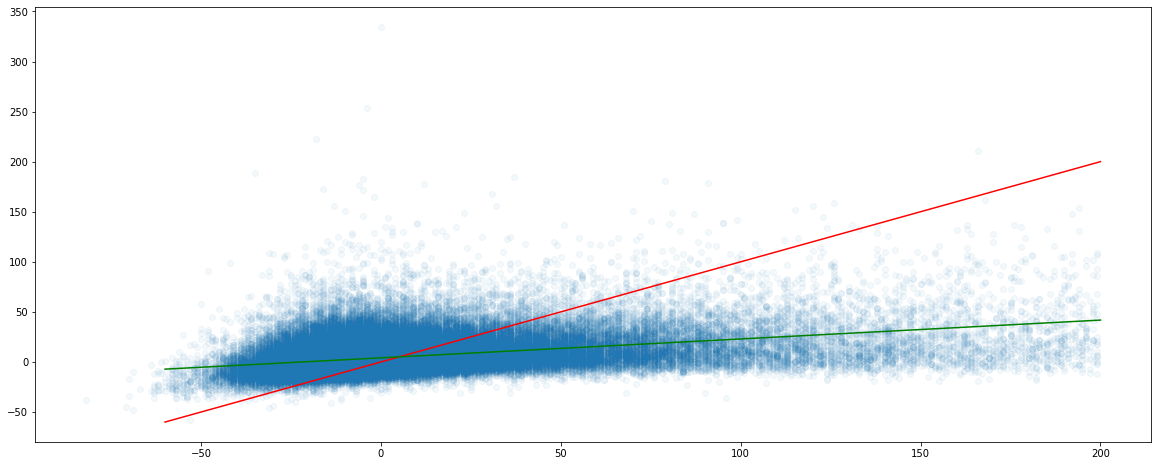

In [ ]:
plt.figure(figsize=(20,8))
plt.scatter(y_test_regr[y_test_regr<200],y_pred,alpha=0.05)
plt.plot([-60,200],[-60,200], 'r-')
plt.plot([-60,200],model.predict([[-60],[200]]), 'g-')

Il grafico sopra mostra le previsione dei ritardi, si vede come, mediamente, la previsione dei voli (linea verde) con un ritardo elevato disti molto dalla linea ideale (linea rossa). Buona parte dei voli in anticipo viene invece stimata in ritardo, in alcuni casi con valori anche di molto superiori a 0.

###Risultato con aggiunta del ritardo in partenza
Potremmo invece ottenere ottimi risultati se effettuassimo la previsione nel momento in cui l'aereo parte, conoscendo dunque il ritardo di partenza. Per fare ciò recuperiamo la feature DEP_DELAY, inizialmente scartata e addestriamo nuovamente il modello. Ripetiamo il training e test del modello basato su XGBoost perchè è quello che garantisce l'ottenimento del risultato migliore.

In [ ]:
X_train["DEP_DELAY"] = dep_delay[X_train.index]
X_val["DEP_DELAY"] = dep_delay[X_val.index]
numerical_features.append("DEP_DELAY")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
grid={
    'tree__colsample_bytree': [0.5,0.6], 
    'tree__learning_rate': [0.01], 
    'tree__max_depth': [15,18], 
    'tree__min_child_weight': [12], 
    'tree__n_estimators': [700,1000], 
    'tree__reg_alpha': [4,6], 
    'tree__reg_lambda': [2,4]
    }

In [ ]:
tree_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("tree", XGBRegressor(random_state=99,objective='reg:squarederror'))
])

In [ ]:
gs = grid_search_with_cross_validation(tree_model,grid,X_train,y_train,X_val,y_val)

Best cross validation score: 0.9123962340297661

             Test set score: 0.9167889169493779

                Best params: {'tree__colsample_bytree': 0.5, 'tree__learning_rate': 0.01, 'tree__max_depth': 18, 'tree__min_child_weight': 12, 'tree__n_estimators': 1000, 'tree__reg_alpha': 6, 'tree__reg_lambda': 2}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['FL_DATE', 'CRS_DEP_TIME',
                                             

Come previsto l'accuratezza del modello migliora notevolmente. Ciò è dovuto al fatto che il ritardo totale di un aereo è costituito per la maggior parte dal ritardo accumulato in partenza, di conseguneza la previsione risulta più semplice e di conseguenza migliore.

##Modelli di classificazione

In questa sezione verranno analizzati vari modelli di classificazione, che stimino per ogni volo l'appartenenza ad una delle classi di ritardo sopra individuate.
Per fare ciò vengono presi in considerazione una serie di algoritmi.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTENC

In [64]:
y_train,y_val, y_test = y_train_class,y_val_class, y_test_class

Per ogni modello preso in considerazione vengono valutate Precision, Recall e F1_Measure. Di seguito viene quindi definita una funzione che effettua le misure e ne stampa il risultato. Viene inoltre visualizzata la matrice di confusione con lo scopo di mostrare come il modello distribuisce i valori nelle varie classi.

In [66]:
def calculate_precision_recall_f1(model, X, y) :
    y_pred = model.predict(X)
    
    precision = precision_score(y, y_pred,average='weighted')
    recall = recall_score(y, y_pred,average='weighted')
    score = f1_score(y, y_pred, average='weighted')
    
    print("Confusion matrix:\n{}\n\n \
           Precision: {}\n \
              Recall: {}\n \
    F1 Score (macro): {}\n\n\n".format(pd.DataFrame(confusion_matrix(y, y_pred), index=cols, columns=cols), 
                                 precision, 
                                 recall, 
                                 score))

In [ ]:
class_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("class", LogisticRegression(solver="saga", random_state=99,n_jobs=-1, multi_class='ovr'))
])
class_model.fit(X_train,y_train)
calculate_precision_recall_f1(class_model,X_val,y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:
           0_to_30  30_to_120  on_time  over_120
0_to_30        141         22    41362         0
30_to_120       89         21    16487         0
on_time        178         24   110680         0
over_120        28          6     4655         0

            Precision: 0.5127835271090202
               Recall: 0.6381489179183962
     F1 Score (macro): 0.4993079575124424





In [67]:
cols = y_val.unique().categories.sort_values()

In [68]:
col = numerical_features + list(class_model.named_steps.preproc.named_transformers_.categorical.get_feature_names(categorical_features))

Dai primi risultati ottenuti dalla LogisticRegression notiamo che nessun volo viene attribuito alla classe di ritardo "over_120" e generalmente vediamo che la maggior parte dei voli viene attribuito alla classe "on_time". Ciò è dovuto al fatto che il problema è altamente sbilanciato, infatti i voli in orario costituiscono più del 60% dei totali. Si sceglie quindi di applicare oversampling dei dati sfruttando SMOTE. In questo modo viene aumentato il numero di istanze delle classi meno popolate, rendendo quindi il problema più distribuito e il training del modello più bilanciato. In particolare si utilizza SMOTENC, un'implementazione di SMOTE che attua oversampling anche sulle variabili categoriche.

In [ ]:
s=SMOTENC([X_train.columns.get_loc(k) for k in categorical_features])
X_t,y_t=s.fit_resample(X_train,y_train)
X_train = pd.DataFrame(X_t,columns=X_train.columns)
y_train = pd.Series(y_t)

Utilizzando SMOTE il numero di istanze cresce, di conseguenza si applica il sample per avere meno istanze da elaborare, velocizzando in questo modo i processi di training e test per i modelli più complessi.

In [ ]:
X_train_sample = X_train.sample(frac = 0.7)
y_train_sample = y_train[X_train_sample.index]

In [ ]:
class_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("class", LogisticRegression(solver="saga", random_state=99,n_jobs=-1,multi_class='ovr'))
])
class_model.fit(X_train,y_train)
calculate_precision_recall_f1(class_model,X_val,y_val)

Confusion matrix:
           0_to_30  30_to_120  on_time  over_120
0_to_30      10681       6896    14954      8994
30_to_120     3267       3574     4402      5354
on_time      23575      13501    50514     23292
over_120       710        907     1226      1846

            Precision: 0.5353488408838534
               Recall: 0.38352150057860707
     F1 Score (macro): 0.4371625318426428





Applicando SMOTE notiamo che il modello non prevede più un'unica classe, ma predice anche le classi che in origine erano meno numerose. In questo modo aumenta la precision del modello pagando tuttavia una diminuzione della recall.
Proviamo ora a testare più modelli per poi confrontarli ed estrarre il migliore.

###Logistic Regression

In [ ]:
grid =  [
         {
            "class__penalty" : ['l1','l2'],
            "class__multi_class" : ['multinomial','ovr'],
            "class__C" : [0.1,1,10]
        },
        {
            "class__penalty" : ['elasticnet'],
            "class__multi_class" : ['multinomial','ovr'],
            "class__C" : [0.1,1,10],
            "class__l1_ratio" : [0.5,0.7]
        } 
      ]        

In [ ]:
class_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("class", LogisticRegression(solver="saga", random_state=99,n_jobs=-1))
])
gs = grid_search_with_cross_validation(class_model,grid,X_train,y_train,X_val,y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best cross validation score: 0.3641930921972299

             Test set score: 0.38226065529411085

                Best params: {'class__C': 10, 'class__multi_class': 'ovr', 'class__penalty': 'l1'}



In [ ]:
logistic_model = gs.best_estimator_
calculate_precision_recall_f1(logistic_model,X_val,y_val)

Confusion matrix:
           0_to_30  30_to_120  on_time  over_120
0_to_30      10658       7079    14870      8918
30_to_120     3301       3632     4383      5281
on_time      23612      13847    50266     23157
over_120       703        924     1222      1840

            Precision: 0.5350691107196116
               Recall: 0.38226065529411085
     F1 Score (macro): 0.43597573191533817





Il risultato ottenuto non è particolarmente soddisfacente, ciò è dovuto al fatto che i dati in esame non sono separabili con un classificatore lineare. Si testano ora dei classificatori non lineari.

###K-Neighbor

In [ ]:
grid =  {
            "class__weights" : ["uniform"],
            "class__n_neighbors" : [15,20,25]
        }        

In [ ]:
model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("class", KNeighborsClassifier(n_jobs=-1))
])
gs = grid_search_with_cross_validation(model,grid,X_train_sample,y_train_sample,X_val,y_val)

Best cross validation score: 0.5359747698086808

             Test set score: 0.505990454422458

                Best params: {'class__n_neighbors': 25, 'class__weights': 'uniform'}



In [ ]:
knn_model = gs.best_estimator_
calculate_precision_recall_f1(knn_model,X_val,y_val)

Confusion matrix:
           0_to_30  30_to_120  on_time  over_120
0_to_30      10771       5696    22364      2694
30_to_120     3973       3461     7530      1633
on_time      20579      11072    73077      6154
over_120       969        908     2234       578

            Precision: 0.5314382491609985
               Recall: 0.505990454422458
     F1 Score (macro): 0.5174703489272331





###Alberi di classificazione

####Decision Tree

In [ ]:
grid =  {
            "class__max_depth" : [16,20,24],
            "class__min_samples_split" : [6,8, 10]
        } 

In [ ]:
class_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
      ("class", DecisionTreeClassifier())
])
gs = grid_search_with_cross_validation(class_model,grid,X_train,y_train,X_val,y_val)

Best cross validation score: 0.5456234083554214

             Test set score: 0.5198367234143

                Best params: {'class__max_depth': 24, 'class__min_samples_split': 6}



In [ ]:
decision_tree_model = gs.best_estimator_
calculate_precision_recall_f1(decision_tree_model,X_val,y_val)

Confusion matrix:
           0_to_30  30_to_120  on_time  over_120
0_to_30       9574       5068    23957      2926
30_to_120     3580       3381     7615      2021
on_time      19171       9082    76456      6173
over_120       818        953     2037       881

            Precision: 0.5319666851288308
               Recall: 0.5198367234143
     F1 Score (macro): 0.5243828211051681





####Random Forest

In [ ]:
grid =  {
            "class__max_depth" : [14,18],
            "class__n_estimators" : [600,800],
            "class__min_samples_split" : [6,8]
        } 

In [ ]:
class_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("class", RandomForestClassifier(random_state=99))
])
gs = grid_search_with_cross_validation(class_model,grid,X_train,y_train,X_val,y_val)

Best cross validation score: 0.49326578196877574

             Test set score: 0.4845733564392347

                Best params: {'class__max_depth': 18, 'class__min_samples_split': 8, 'class__n_estimators': 800}



In [ ]:
random_forest_model = gs.best_estimator_
calculate_precision_recall_f1(random_forest_model,X_val,y_val)

Confusion matrix:
           0_to_30  30_to_120  on_time  over_120
0_to_30       6422       6660    21531      6912
30_to_120     2140       3775     6366      4316
on_time      11545      11261    72374     15702
over_120       404        891     1798      1596

            Precision: 0.5449888276386357
               Recall: 0.4845733564392347
     F1 Score (macro): 0.5044251984519443





####XGBoost

In [ ]:
"""grid = {
    "class__max_depth" : [15,18],
    "class__colsample_bytree" : [0.6,0.8],
    "class__n_estimators" : [800],
    "class__reg_alpha" : [4,6],
    "class__reg_lambda" : [2,4],
    "class__subsample" : [0.5,0.6],
    "class__n_jobs" : [-1],
    "class__objective" : ["multi:softmax"],
    "class__learning_rate" : [0.01]
}"""

In [ ]:
best_params = {
    "max_depth" : 18,
    "colsample_bytree" : 0.6,
    "n_estimators" : 800,
    "reg_alpha" : 6,
    "reg_lambda" : 4,
    "subsample" : 0.5,
    "objective" : "multi:softmax",
    "learning_rate" : 0.01,
    "n_jobs" : -1
}

In [ ]:
xgb_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("class", XGBClassifier(**best_params))
])
xgb_model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['FL_DATE', 'CRS_DEP_TIME',
                                                   'CRS_ARR_TIME',
                                                   'CRS_ELAPSED_TIME',
                                                   'DISTANCE']),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                                      

In [ ]:
calculate_precision_recall_f1(xgb_model,X_val,y_val)

Confusion matrix:
           0_to_30  30_to_120  on_time  over_120
0_to_30       6440       3608    30235      1242
30_to_120     2261       3256     9773      1307
on_time       8306       4902    95747      1927
over_120       413        827     2658       791

            Precision: 0.5587404337043058
               Recall: 0.611619351384339
     F1 Score (macro): 0.5682118488961063





####XGBoost Regressione

Si prova anche ad utilizzare il modello migliore della regressione. Il risultato viene poi mappato nelle varie classi di ritardo.

In [ ]:
best_params={
    'colsample_bytree': 0.5, 
    'learning_rate': 0.01, 
    'max_depth': 18, 
    'min_child_weight': 12, 
    'n_estimators': 1000, 
    'reg_alpha': 4, 
    'reg_lambda': 2
    }

In [ ]:
xgb_regr_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("tree", XGBRegressor(**best_params,random_state=99,objective='reg:squarederror'))
])
xgb_regr_model.fit(X_train,y_train_regr)
regr_results = pd.Series(xgb_regr_model.predict(X_val)).map(class_mapping)

In [ ]:
print("Confusion matrix:\n{}\n\n \
           Precision: {}\n \
              Recall: {}\n \
    F1 Score (macro): {}\n\n\n".format(pd.DataFrame(confusion_matrix(y_val,regr_results),index=cols,columns=cols), 
                                 precision_score(y_val,regr_results,average='weighted'), 
                                 recall_score(y_val,regr_results,average='weighted'), 
                                 f1_score(y_val,regr_results,average='weighted')))




Confusion matrix:
           0_to_30  30_to_120  on_time  over_120
0_to_30      25174       2572    13757        22
30_to_120    10372       3252     2946        27
on_time      47249       2875    60732        26
over_120      2337       1552      732        68

            Precision: 0.6098350237583537
               Recall: 0.5136994582395376
     F1 Score (macro): 0.5291009410852858





####Modello casuale

In [ ]:
from sklearn.dummy import DummyClassifier

Di seguito si testa anche un modello che prevede i dati in maniera casuale.

In [ ]:
dummy_model = Pipeline([
       ("preproc", ColumnTransformer([
          ( "numeric"    , StandardScaler(), numerical_features),
          ( "categorical", OneHotEncoder() , categorical_features)                       
       ])),
       ("class", DummyClassifier(strategy='stratified',random_state=99))            
])
dummy_model.fit(X_train,y_train)
calculate_precision_recall_f1(dummy_model,X_val,y_val)

Confusion matrix:
           0_to_30  30_to_120  on_time  over_120
0_to_30      10088       3975    26438      1024
30_to_120     4082       1569    10538       408
on_time      26423      10530    70974      2955
over_120      1109        456     3001       123

            Precision: 0.4760024029410956
               Recall: 0.4764383135762523
     F1 Score (macro): 0.47621974612857065





In questo caso il modello effettua la classificazione riproducendo l'andamento dei dati sui quali è stato eseguito il fit di conseguenza ottiene un risultato abbastanza buono, che rimane comunque peggiore rispetto ai modelli addestrati con criterio.

####Considerazioni finali

In generale per la classificazione possiamo dire che, come visto già per i modelli di regressione, i modelli che sfruttano gli alberi sono migliori rispetto agli altri. Tra questi quello che ha avuto in entrambi i casi il risultato migliore è XGBoost. XGBoost ottiene risultati migliori perchè si comporta molto bene con i voli on_time, rimanendo prudente nel classificare un volo in ritardo. Ciò porta ad avere meno voli classificati in ritardo a differenza di altri modelli che cercano di ottenere risultati migliori sui voli i ritardo andando a sacrificare la corretta classificazione dei voli in orario. XGBoost rappresenta dunque un compromesso tra un modello che classifica gran parte dei voli come "on_time" (LogisticRegression pre SMOTE) e un modello che cerca invece di ottenere risultati migliori sui voli in ritardo (LogisticRegression post SMOTE).Gli altri modelli non raggiungono lo stesso compromesso, rimangono infatti molto vicini a LogisticRegression dopo l'applicazione di SMOTE.

###Confronto tra i modelli

Confrontiamo ora i modelli per vedere se esiste una differenza statisticamente significativa tra di essi

In [ ]:
logistic_error= 1 - f1_score(y_test_class,logistic_model.predict(X_test),average='weighted')
knn_error= 1 - f1_score(y_test_class,knn_model.predict(X_test),average='weighted')
decision_tree_error= 1 - f1_score(y_test_class,decision_tree_model.predict(X_test),average='weighted')
random_forest_error= 1 - f1_score(y_test_class,random_forest_model.predict(X_test),average='weighted')
xgb_error = 1 - f1_score(y_test_class,xgb_model.predict(X_test),average='weighted')
xgb_regr_error = 1-f1_score(y_test,xgb_regr_model.predict(X_test),average='weighted')
dummy_error = 1- f1_score(y_test,dummy_model.predict(X_test),average='weighted')

#####Logistic vs K-Neighbor

In [ ]:
print('Interval {}'.format(np.round(model_comparison(logistic_error,knn_error),4)))

Interval [0.0763 0.0836]


#####Logistic vs DecisionTree

In [ ]:
print('Interval {}'.format(np.round(model_comparison(logistic_error,decision_tree_error),4)))

Interval [0.0841 0.0914]


#####XGBoost vs Logistic

In [ ]:
print('Interval {}'.format(np.round(model_comparison(xgb_error,logistic_error),4)))

Interval [0.1286 0.1359]


#####XGBoost vs K-Neighbors

In [ ]:
print('Interval {}'.format(np.round(model_comparison(xgb_error,knn_error),4)))

Interval [0.0487 0.056 ]


#####XGBoost vs DecisionTree

In [ ]:
print('Interval {}'.format(np.round(model_comparison(xgb_error,decision_tree_error),4)))

Interval [0.0409 0.0482]


#####XGBoost vs RandomForest

In [73]:
print('Interval {}'.format(np.round(model_comparison(xgb_error,random_forest_error),4)))

Interval [0.0594 0.0667]


####XGBoost classificazione vs XGBoost regressione

In [ ]:
print('Interval {}'.format(np.round(model_comparison(xgb_error,xgb_regr_error),4)))

Interval [0.0358 0.0431]


####XGBoost vs Dummy

In [ ]:
print('Interval {}'.format(np.round(model_comparison(xgb_error,dummy_error),4)))

Interval [0.0936 0.1009]


Confrontando fra loro i modelli si nota come tutti abbiano differenze statisticamente significative in quanto gli intervalli di confidenza calcolati non contengono il valore 0. Il modello migliore si conferma dunque XGBoost che, pagando una complessità superiore in fase di training e predizione, ottiene un risultato migliore rispetto agli altri modelli considerati.


###Valutazione del modello migliore


Si valuta ora l'intervallo di confidenza del modello migliore.

In [77]:
from statsmodels.stats.proportion import proportion_confint

def confidence_interval(n, acc, confidence):    
    return proportion_confint(n * acc, n, 1-confidence/100, method='wilson')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [79]:
confidence = 95
lower, upper = confidence_interval(len(X_test), xgb_model.score(X_test), confidence)

print('Interval with confidence {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower*100, upper*100))

Interval with confidence 95%: 
Pmin = 60.9082%
Pmax = 61.4150%
